In [1]:
%reload_kedro

2020-04-10 17:01:35,261 - root - INFO - ** Kedro project Dynamic Topic Modeling
2020-04-10 17:01:35,262 - root - INFO - Defined global variable `context` and `catalog`
Traceback (most recent call last):
  File "/home/ridouane/anaconda3/envs/dynamic-topic-modeling/lib/python3.6/site-packages/kedro/cli/cli.py", line 589, in load_entry_points
    entry_point_commands.append(entry_point.load())
  File "/home/ridouane/anaconda3/envs/dynamic-topic-modeling/lib/python3.6/site-packages/pkg_resources/__init__.py", line 2449, in load
    self.require(*args, **kwargs)
  File "/home/ridouane/anaconda3/envs/dynamic-topic-modeling/lib/python3.6/site-packages/pkg_resources/__init__.py", line 2472, in require
    items = working_set.resolve(reqs, env, installer, extras=self.extras)
  File "/home/ridouane/anaconda3/envs/dynamic-topic-modeling/lib/python3.6/site-packages/pkg_resources/__init__.py", line 792, in resolve
    raise VersionConflict(dist, req).with_context(dependent_req)
pkg_resources.Versio

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Document embedding:
## Bag of Words / tf-idf
## Sum / Mean of word embeddings
## Doc2Vec
## BERT

# Document distance:
## Euclidean / Cosine distance
## Word Movers' Distance

In [4]:
train_docs = catalog.load('train_docs')
train_corpus = catalog.load('train_corpus')
val_docs = catalog.load('val_docs')
val_corpus = catalog.load('val_corpus')
dictionary = catalog.load('dictionary')

2020-04-10 17:01:35,824 - kedro.io.data_catalog - INFO - Loading data from `train_docs` (PickleLocalDataSet)...
2020-04-10 17:01:36,499 - kedro.io.data_catalog - INFO - Loading data from `train_corpus` (MmCorpusDataSet)...
2020-04-10 17:01:36,501 - gensim.corpora.indexedcorpus - INFO - loaded corpus index from data/05_model_input/train_corpus.mm.index
2020-04-10 17:01:36,502 - gensim.corpora._mmreader - INFO - initializing cython corpus reader from data/05_model_input/train_corpus.mm
2020-04-10 17:01:36,503 - gensim.corpora._mmreader - INFO - accepted corpus with 6006 documents, 5778 features, 3683220 non-zero entries
2020-04-10 17:01:36,504 - kedro.io.data_catalog - INFO - Loading data from `val_docs` (PickleLocalDataSet)...
2020-04-10 17:01:36,771 - kedro.io.data_catalog - INFO - Loading data from `val_corpus` (MmCorpusDataSet)...
2020-04-10 17:01:36,780 - gensim.corpora.indexedcorpus - INFO - loaded corpus index from data/05_model_input/val_corpus.mm.index
2020-04-10 17:01:36,782 - 

## Bag of Words / tf-idf

In [5]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

In [6]:
tmp = [' '.join(doc) for doc in train_docs]
pipe = Pipeline([('count', CountVectorizer(vocabulary=list(dictionary.token2id))),
                 ('tfid', TfidfTransformer())]).fit(tmp)

In [ ]:
train_bow = pipe['count'].transform(tmp).toarray()
train_bow = train_bow / train_bow.sum(axis=1, keepdims=True)
train_tfidf = pipe.transform(tmp).toarray()

## Sum / Mean of word embeddings

In [60]:
dict = catalog.load('dict_embeddings_norm')

2020-04-03 13:37:55,332 - kedro.io.data_catalog - INFO - Loading data from `dict_embeddings_norm` (PickleLocalDataSet)...


In [79]:
train_concat_emb = []
for doc in train_docs:
    doc_emb = []
    for w in doc:
        if w in dict:
            doc_emb.append(dict[w])
    doc_emb = np.array(doc_emb)
    #train_concat_emb.append(doc_emb.sum(axis=0))
    train_concat_emb.append(doc_emb.mean(axis=0))
train_concat_emb = np.array(train_concat_emb)

## Doc2Vec

In [5]:
doc_embeddings = catalog.load('doc_embeddings')
doc_embeddings_norm = catalog.load('doc_embeddings_norm')

2020-04-10 17:01:38,891 - kedro.io.data_catalog - INFO - Loading data from `doc_embeddings` (PickleLocalDataSet)...
2020-04-10 17:01:38,900 - kedro.io.data_catalog - INFO - Loading data from `doc_embeddings_norm` (PickleLocalDataSet)...


## Clustering

In [6]:
corpus = doc_embeddings_norm

In [7]:
from sklearn.cluster import KMeans

num_topics = 50
model = KMeans(n_clusters=num_topics).fit(corpus)

In [8]:
from sklearn.preprocessing import OneHotEncoder

vocab_size = len(dictionary)

preds = model.predict(corpus)
preds = preds.reshape((-1, 1))
enc = OneHotEncoder(handle_unknown='ignore').fit(preds)
theta = enc.transform(preds).toarray()

In [9]:
beta = np.zeros((num_topics, vocab_size))
for i,doc in enumerate(train_docs):
    topic_id = preds[i][0]
    for w in doc:
        beta[topic_id][dictionary.token2id[w]] += 1
beta = beta / beta.sum(axis=1, keepdims=True)

In [13]:
import pickle
with open('./data/06_models/trained_model_kmeans_docs.sav', 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('./data/07_model_output/beta.pkl', 'wb') as handle:
    pickle.dump(beta, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('./data/07_model_output/theta.pkl', 'wb') as handle:
    pickle.dump(theta, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Eval model

In [11]:
model = catalog.load('trained_model_kmeans_docs')

2020-04-10 13:24:23,981 - kedro.io.data_catalog - INFO - Loading data from `trained_model_kmeans_docs` (PickleLocalDataSet)...


In [10]:
from scipy.spatial.distance import jensenshannon
from sklearn.manifold import MDS

def extract_top_n_words(topic_distributions, dictionary, topic_id, top_n):
    top_n_words = [dictionary[np.argsort(topic_distributions[topic_id])[-i-1]] for i in range(top_n)]
    top_n_freqs = [np.sort(topic_distributions[topic_id])[-i-1] for i in range(top_n)]
    return top_n_words, top_n_freqs

def calculate_topic_distances(topic_distributions):
    num_topics = len(topic_distributions)
    distances = np.zeros((num_topics, num_topics))
    for i in range(num_topics):
        for j in range(num_topics):
            topic_i, topic_j = topic_distributions[i], topic_distributions[j]
            distances[i][j] = jensenshannon(topic_i, topic_j)
    return distances

def show_most_m_represantative_docs(doc_topic, m, docs, topic_id):
    indices_max = np.argsort(doc_topic[:,topic_id])[-m:]
    verbatims = []
    for idx in reversed(indices_max):
        doc = docs[idx]
        verbatims.append(' '.join(list(doc)))
    return verbatims

def occ_dict(doc):
    occurences_dict = {}
    for word in doc:
        if word in occurences_dict:
            occurences_dict[word] += 1
        else:
            occurences_dict[word] = 1
    return occurences_dict

def get_Dwi(wi, doc_dicts):
    Dwi = 0
    for doc_dict in doc_dicts:
        if wi in doc_dict:
            Dwi += doc_dict[wi]
    return Dwi

def get_Dwiwj(wi, wj, doc_dicts):
    Dwiwj = 0
    for doc_dict in doc_dicts:
        if wi in doc_dict and wj in doc_dict:
            Dwiwj += doc_dict[wi] * doc_dict[wj]
    return Dwiwj

def topic_coherence(topic_distributions, dictionary, topic_id, top_n, docs, method='umass', eps=1e-5):
    top_words, _ = extract_top_n_words(topic_distributions, dictionary, topic_id, top_n)

    N = top_n - 1

    D = 0
    for doc in docs:
        D += len(doc)
    #D = len(docs)

    # remplacer par un CountVectorizer
    doc_dicts = [occ_dict(doc) for doc in docs]

    score = 0.
    for i in range(1, N):
        for j in range(i):
            wi = top_words[i]
            wj = top_words[j]

            Dwj = get_Dwi(wj, doc_dicts)
            Dwiwj = get_Dwiwj(wi, wj, doc_dicts)

            pwj = Dwj / D
            pwiwj = Dwiwj / D

            # umass
            if method == 'umass':
                score += np.log((pwiwj + eps) / pwj)

            # pmi
            elif method == 'pmi':
                Dwi = get_Dwi(wi, doc_dicts)
                pwi = Dwi / D
                score += np.log((pwiwj + eps) / (pwi * pwj))

            # npmi
            elif method == 'npmi':
                Dwi = get_Dwi(wi, doc_dicts)
                pwi = Dwi / D

                if Dwiwj == 0:
                    score += -1.
                elif Dwiwj == Dwi and Dwiwj == Dwj:
                    score += 1.
                else:
                    score += np.log((pwiwj + eps) / (pwi * pwj)) / (- np.log(pwiwj + eps))

    return score / (2 * N * (N - 1))

def topic_diversity(topic_distributions, dictionary, top_n):
    top_words = []
    num_topics = len(topic_distributions)
    for k in range(num_topics):
        tmp, _ = extract_top_n_words(topic_distributions, dictionary, k, top_n)
        top_words += tmp
    return len(np.unique(top_words)) / len(top_words)

In [11]:
def visualize_topics(beta, dictionary, top_n_show=5):
    distances = calculate_topic_distances(beta)
    mds = MDS(n_components=2, max_iter=3000, eps=1e-9, dissimilarity="precomputed", n_jobs=1)
    pos = mds.fit(distances).embedding_
    plt.figure(figsize=(20,20))
    plt.scatter(pos[:, 0], pos[:, 1], s=100, lw=0)

    words = [[]]*num_topics
    for topic_id in range(num_topics):
        top_n_words, _ = extract_top_n_words(beta, dictionary, topic_id, top_n_show)
        words[topic_id] = top_n_words
    for topic_id in range(num_topics):
        plt.text(pos[topic_id, 0]+0.01, pos[topic_id, 1]+0.01*top_n_show, 'Topic '+str(topic_id), c='blue')
        for k in range(top_n_show):
            plt.text(pos[topic_id, 0]+0.01, pos[topic_id, 1]-(k+1)*0.01+0.01*top_n_show, words[topic_id][k])

    plt.show()

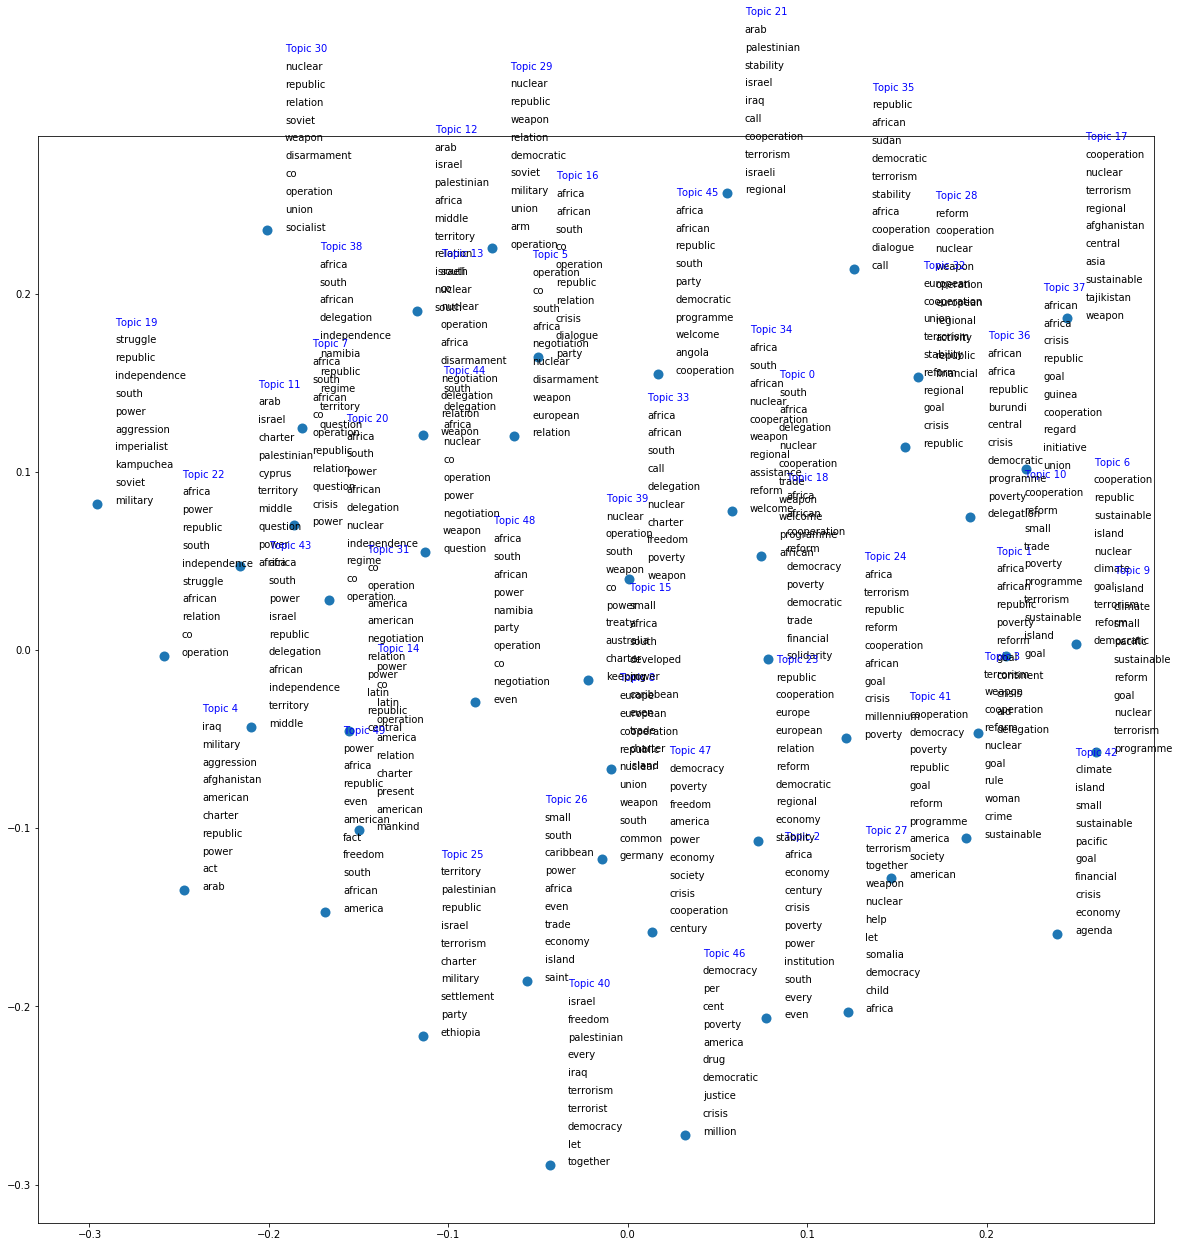

In [12]:
visualize_topics(beta, dictionary, top_n_show=10)

In [15]:
def eval_model(topic_distributions, doc_topic_matrix, dictionary, train_docs,
               num_topics, top_n_show=10, m_most=1, top_n_coherence=10, top_n_diversity=25):

    # Metrics

    ## Qualitative Metrics

    ### Top-n words per topic
    for topic_id in range(num_topics):
        top_n_words, top_n_freqs = extract_top_n_words(topic_distributions, dictionary, topic_id, top_n_show)

        plt.figure(figsize=(10, 4))
        plt.title('Topic number ' + str(topic_id))
        plt.bar(top_n_words, top_n_freqs)
        plt.show()

    ### Topic sizes
    #

    ### Topic distances
    distances = calculate_topic_distances(topic_distributions)
    plt.figure(figsize=(6, 6))
    plt.imshow(distances, cmap='Greys')
    plt.show()

    mds = MDS(n_components=2, max_iter=3000, eps=1e-9, dissimilarity="precomputed", n_jobs=1)
    pos = mds.fit(distances).embedding_
    plt.figure(figsize=(6, 6))
    plt.scatter(pos[:, 0], pos[:, 1], s=100, lw=0)
    plt.show()

    ### Most m representative documents
    for topic_id in range(num_topics):
        print('Topic number ', topic_id, show_most_m_represantative_docs(doc_topic_matrix, m_most, train_docs, topic_id))


    ## Quantitative Metrics

    ### Topic Coherence
    mean_tc = 0.
    for topic_id in range(num_topics):
        tc = topic_coherence(topic_distributions, dictionary, topic_id, top_n_coherence, train_docs, method='npmi')
        print('Topic number ', topic_id, 'tc:', tc)
        mean_tc += tc
    print('Topic coherence:', mean_tc / num_topics)

    ### Topic Diversity
    print('Topic diversity', topic_diversity(topic_distributions, dictionary, top_n_diversity))

    ### Predictive Quality
    #

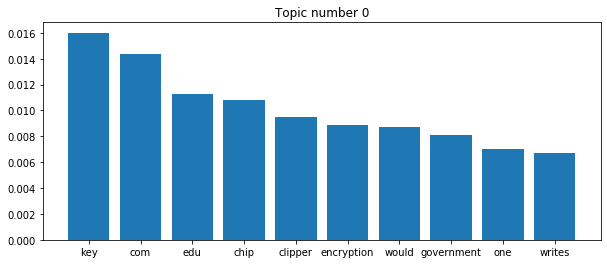

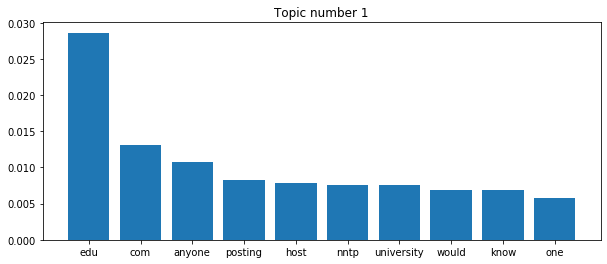

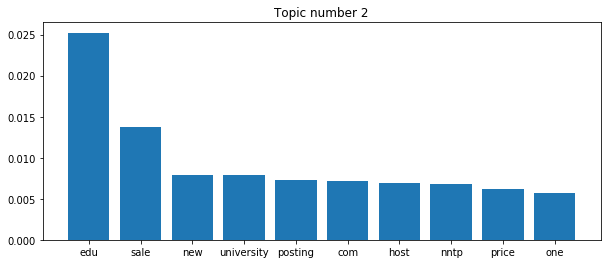

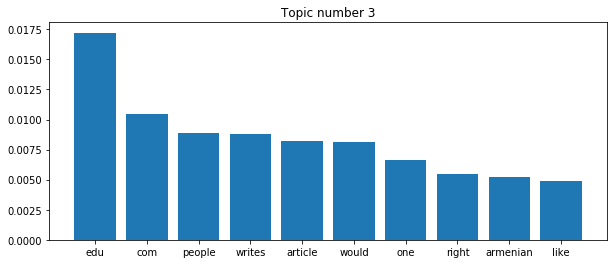

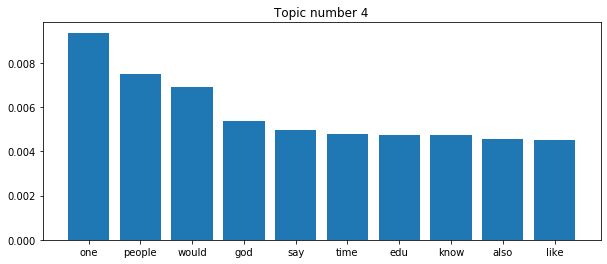

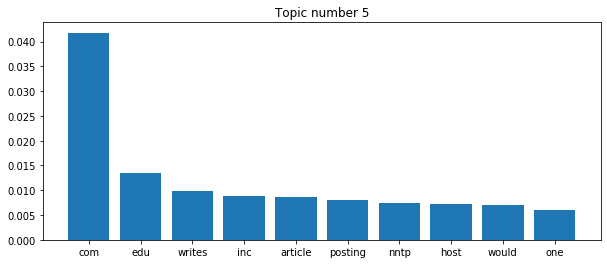

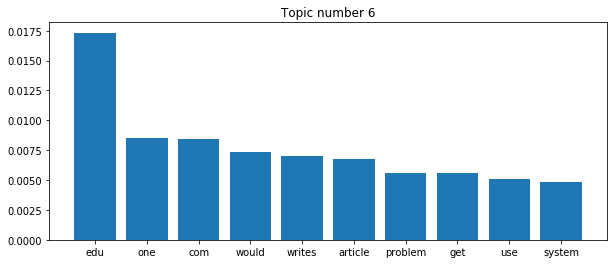

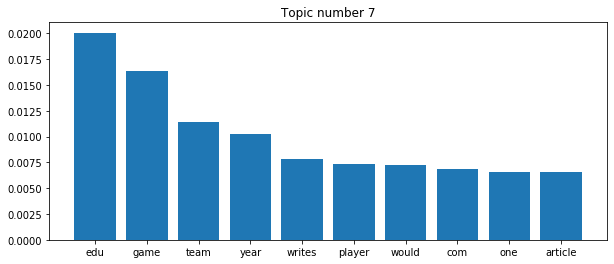

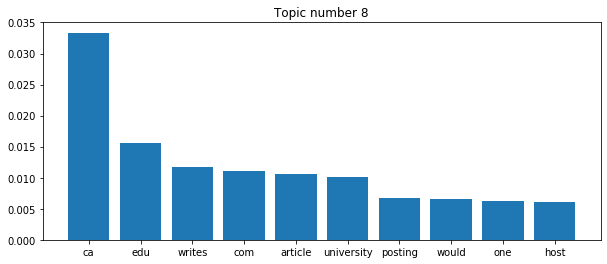

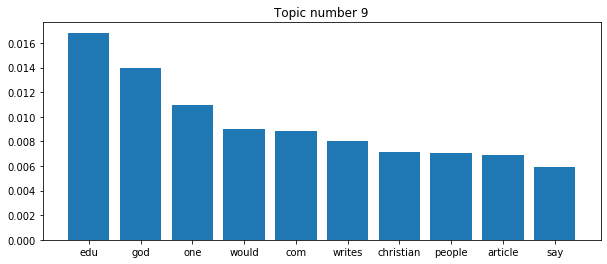

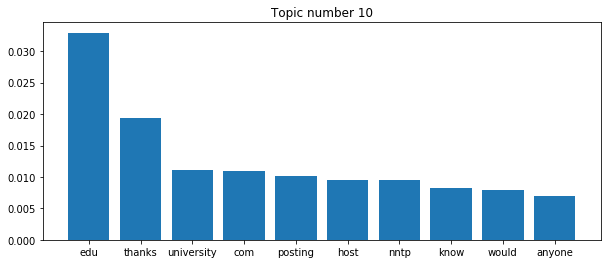

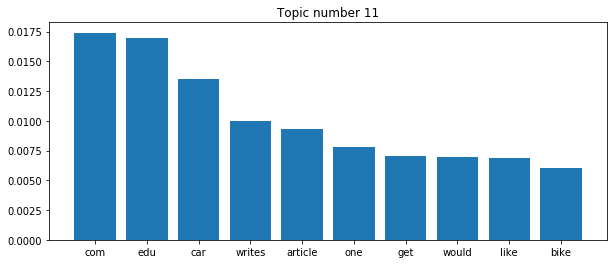

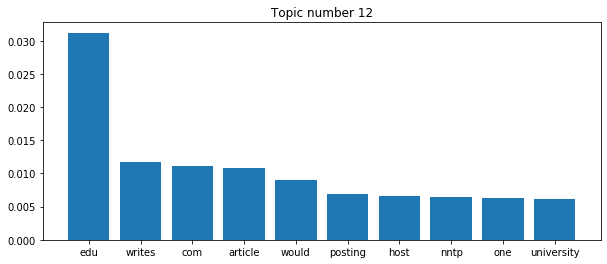

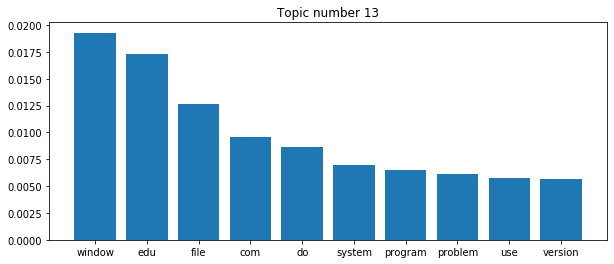

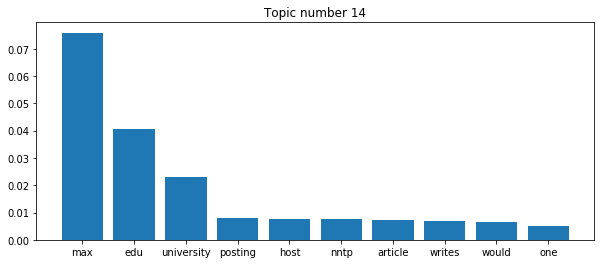

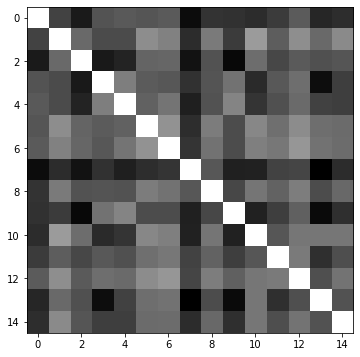

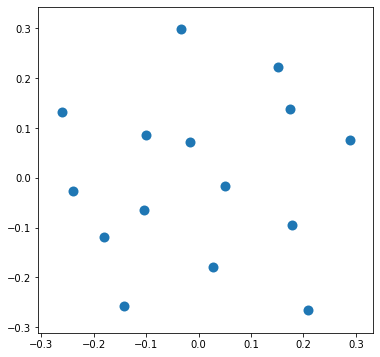

Topic number  0 ['com opinion shot government system federal system division va distribution world reply com nntp posting host com news software vax vms vnews article bitnet bitnet writes might look doctor area us drop instead shot treatment given small drop placed minute tried one month drop three time day notice change ever long using drop noticed difference treatment expensive insurance cover medicine']
Topic number  1 ['edu pat mail car club nntp posting host edu north higher education computing network newsreader tin version pl8 interested know mail car club anyone started one anybody thinking starting one thanks info give edu']
Topic number  2 ['rich unc edu rich pa week sale nntp posting host unc edu university north extended board service distribution usa second week prime season one area north sleep depending hot easy access lot shuttle mile cost price based paid used also current market opinion expressed necessarily university north hill campus office information technology b

Topic number  0 tc: 0.266175302944519
Topic number  1 tc: 0.23275510256740015
Topic number  2 tc: 0.2205757966087997
Topic number  3 tc: 0.28420202490003793
Topic number  4 tc: 0.3332610890252665
Topic number  5 tc: 0.24059083480645574
Topic number  6 tc: 0.28570849904494794
Topic number  7 tc: 0.26572107986575916
Topic number  8 tc: 0.2553709739753315
Topic number  9 tc: 0.28017519603077995
Topic number  10 tc: 0.22930042715819557
Topic number  11 tc: 0.2755122692611356
Topic number  12 tc: 0.25732189214522794
Topic number  13 tc: 0.3842787483336388
Topic number  14 tc: 0.20836110183568088
Topic coherence: 0.26795402256687845
Topic diversity 0.304


In [16]:
eval_model(beta, theta, dictionary, train_docs, num_topics, 
           top_n_show=10, m_most=1, top_n_coherence=10, top_n_diversity=25)